# Intelligent Agents: Reflex-Based Agents for the Vacuum-cleaner World

Student Name: [Add your name]

I have used the following AI tools: [list tools]

I understand that my submission needs to be my own work: [your initials]

## Instructions

Total Points: Undergrads 100 + 5 bonus / Graduate students 110

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Submit the completely rendered notebook as a HTML file.

In Visual Studio Code: Use Export (click on ... in the menu bar) to save your notebook as a HTML file.

In Colab you need to save the notebook on GoogleDrive and then add the following block

In [24]:
# !pip install nbconvert

# from google.colab import drive
# drive.mount('/content/drive')
# !jupyter nbconvert --to html /content/drive/MyDrive/Colab\ Notebooks/Copy\ of\ robot_vacuum.ipynb

You will need to fix the file location on your GoogleDrive.

## Introduction

In this assignment you will implement a simulator environment for an automatic vacuum cleaner robot, a set of different reflex-based agent programs, and perform a comparison study for cleaning a single room. Focus on the __cleaning phase__ which starts when the robot is activated and ends when the last dirty square in the room has been cleaned. Someone else will take care of the agent program needed to navigate back to the charging station after the room is clean.

## PEAS description of the cleaning phase

__Performance Measure:__ Each action costs 1 energy unit. The performance is measured as the sum of the energy units used to clean the whole room.

__Environment:__ A room with $n \times n$ squares where $n = 5$. Dirt is randomly placed on each square with probability $p = 0.2$. For simplicity, you can assume that the agent knows the size and the layout of the room (i.e., it knows $n$). To start, the agent is placed on a random square.

__Actuators:__ The agent can clean the current square (action `suck`) or move to an adjacent square by going `north`, `east`, `south`, or `west`.

__Sensors:__ Four bumper sensors, one for north, east, south, and west; a dirt sensor reporting dirt in the current square.  


## The agent program for a simple randomized agent

The agent program is a function that gets sensor information (the current percepts) as the arguments. The arguments are:

* A dictionary with boolean entries for the for bumper sensors `north`, `east`, `west`, `south`. E.g., if the agent is on the north-west corner, `bumpers` will be `{"north" : True, "east" : False, "south" : False, "west" : True}`.
* The dirt sensor produces a boolean.

The agent returns the chosen action as a string.

Here is an example implementation for the agent program of a simple randomized agent:  

In [1]:
# make sure numpy is installed
!pip install -q numpy

In [2]:
import numpy as np

actions = ["north", "east", "west", "south", "suck"]

def simple_randomized_agent(bumpers, dirty):
    return np.random.choice(actions)

In [6]:
# define percepts (current location is NW corner and it is dirty)
bumpers = {"north" : True, "east" : False, "south" : False, "west" : True}
dirty = True

# call agent program function with percepts and it returns an action
simple_randomized_agent(bumpers, dirty)

'west'

__Note:__ This is not a rational intelligent agent. It ignores its sensors and may bump into a wall repeatedly or not clean a dirty square. You will be asked to implement rational agents below.

## Simple environment example

We implement a simple simulation environment that supplies the agent with its percepts.
The simple environment is infinite in size (bumpers are always `False`) and every square is always dirty, even if the agent cleans it. The environment function returns a different performance measure than the one specified in the PEAS description! Since the room is infinite and all squares are constantly dirty, the agent can never clean the whole room. Your implementation needs to implement the **correct performance measure.** The energy budget of the agent is specified as `max_steps`.

In [7]:
def simple_environment(agent, max_steps, verbose = True):
    num_cleaned = 0

    for i in range(max_steps):
        dirty = True
        bumpers = {"north" : False, "south" : False, "west" : False, "east" : False}

        action = agent(bumpers, dirty)
        if (verbose): print("step", i , "- action:", action)

        if (action == "suck"):
            num_cleaned = num_cleaned + 1

    return num_cleaned



Do one simulation run with a simple randomized agent that has enough energy for 20 steps.

In [8]:
simple_environment(simple_randomized_agent, max_steps = 20)

step 0 - action: east
step 1 - action: east
step 2 - action: south
step 3 - action: east
step 4 - action: south
step 5 - action: north
step 6 - action: suck
step 7 - action: west
step 8 - action: south
step 9 - action: west
step 10 - action: suck
step 11 - action: south
step 12 - action: north
step 13 - action: east
step 14 - action: suck
step 15 - action: east
step 16 - action: north
step 17 - action: east
step 18 - action: east
step 19 - action: south


3

# Tasks

## General [10 Points]

1. Make sure that you use the latest version of this notebook.
2. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement intelligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
3. You notebook needs to be formatted professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your submitted file is readable. For example, long lines may get cut off. You don't have control over page breaks, so do not worry about these.
4. Document your code. Add a short discussion of how your implementation works and your design choices.


## Task 1: Implement a simulation environment [20 Points]

The simple environment above is not very realistic. Your environment simulator needs to follow the PEAS description from above. It needs to:

* Initialize the environment by storing the state of each square (clean/dirty) and making some dirty. ([Help with random numbers and arrays in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/random_numbers_and_arrays.ipynb))
* Keep track of the agent's position.
* Call the agent function repeatedly and provide the agent function with the sensor inputs.  
* React to the agent's actions. E.g, by removing dirt from a square or moving the agent around unless there is a wall in the way.
* Keep track of the performance measure. That is, track the agent's actions until all dirty squares are clean and count the number of actions it takes the agent to complete the task.

The easiest implementation for the environment is to hold an 2-dimensional array to represent if squares are clean or dirty and to call the agent function in a loop until all squares are clean or a predefined number of steps have been reached (i.e., the robot runs out of energy).

The simulation environment should be a function like the `simple_environment()` and needs to work with the simple randomized agent program from above. **Use the same environment for all your agent implementations in the tasks below.**

*Note on debugging:* Debugging is difficult. Make sure your environment prints enough information when you use `verbose = True`. Also, implementing a function that the environment can use to displays the room with dirt and the current position of the robot at every step is very useful.  

In [9]:
import numpy as np
import random

# Define actions
actions = ["north", "east", "west", "south", "suck"]

# Initialize the environment
def initialize_environment(n=5, p=0.2):
    """Initialize a room with dirt (1 = dirty, 0 = clean)."""
    room = np.random.choice([0, 1], size=(n, n), p=[1-p, p])  # 20% chance of being dirty
    return room

# Display the environment
def display_environment(room, agent_pos):
    """Display the room state and the agent's position."""
    display = room.copy()
    display[agent_pos[0], agent_pos[1]] = 9  # Mark the agent's position with a 9
    print(display)

# Check if all squares are clean
def is_all_clean(room):
    """Return True if all squares are clean, False otherwise."""
    return np.all(room == 0)

# Reflex agent
def simple_randomized_agent(bumpers, dirty):
    """Return a random action based on current bumpers and dirt."""
    if dirty:
        return "suck"
    return np.random.choice(actions[:-1])  # exclude "suck" when not dirty

# Move agent if possible
def move_agent(action, agent_pos, room_size):
    """Update the agent's position based on the chosen action."""
    new_pos = agent_pos[:]
    if action == "north" and agent_pos[0] > 0:
        new_pos[0] -= 1
    elif action == "south" and agent_pos[0] < room_size - 1:
        new_pos[0] += 1
    elif action == "west" and agent_pos[1] > 0:
        new_pos[1] -= 1
    elif action == "east" and agent_pos[1] < room_size - 1:
        new_pos[1] += 1
    return new_pos

# Environment simulation
def vacuum_environment(agent, n=5, p=0.2, max_steps=100, verbose=True):
    # Initialize the environment
    room = initialize_environment(n, p)
    agent_pos = [random.randint(0, n-1), random.randint(0, n-1)]  # Random start position
    energy_used = 0

    if verbose:
        print("Initial Environment:")
        display_environment(room, agent_pos)

    # Simulate agent's actions
    for step in range(max_steps):
        # Get sensor information
        bumpers = {
            "north": agent_pos[0] == 0,
            "south": agent_pos[0] == n-1,
            "west": agent_pos[1] == 0,
            "east": agent_pos[1] == n-1
        }
        dirty = room[agent_pos[0], agent_pos[1]] == 1

        # Get agent's action
        action = agent(bumpers, dirty)

        if verbose:
            print(f"Step {step} - Action: {action}")

        # React to action
        if action == "suck":
            room[agent_pos[0], agent_pos[1]] = 0  # Clean the square
        else:
            agent_pos = move_agent(action, agent_pos, n)  # Move agent

        energy_used += 1  # Each action costs 1 unit of energy

        if verbose:
            display_environment(room, agent_pos)

        # Stop if all squares are clean
        if is_all_clean(room):
            if verbose:
                print(f"All squares are clean in {step+1} steps.")
            break

    return energy_used

# Run simulation
energy = vacuum_environment(simple_randomized_agent, max_steps=100, verbose=True)
print(f"Total energy used: {energy}")


Initial Environment:
[[0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 1 0 1]
 [0 1 0 0 0]
 [1 1 9 0 0]]
Step 0 - Action: north
[[0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 1 0 1]
 [0 1 9 0 0]
 [1 1 0 0 0]]
Step 1 - Action: west
[[0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 1 0 1]
 [0 9 0 0 0]
 [1 1 0 0 0]]
Step 2 - Action: suck
[[0 0 0 0 0]
 [1 0 0 0 0]
 [1 0 1 0 1]
 [0 9 0 0 0]
 [1 1 0 0 0]]
Step 3 - Action: north
[[0 0 0 0 0]
 [1 0 0 0 0]
 [1 9 1 0 1]
 [0 0 0 0 0]
 [1 1 0 0 0]]
Step 4 - Action: north
[[0 0 0 0 0]
 [1 9 0 0 0]
 [1 0 1 0 1]
 [0 0 0 0 0]
 [1 1 0 0 0]]
Step 5 - Action: south
[[0 0 0 0 0]
 [1 0 0 0 0]
 [1 9 1 0 1]
 [0 0 0 0 0]
 [1 1 0 0 0]]
Step 6 - Action: west
[[0 0 0 0 0]
 [1 0 0 0 0]
 [9 0 1 0 1]
 [0 0 0 0 0]
 [1 1 0 0 0]]
Step 7 - Action: suck
[[0 0 0 0 0]
 [1 0 0 0 0]
 [9 0 1 0 1]
 [0 0 0 0 0]
 [1 1 0 0 0]]
Step 8 - Action: west
[[0 0 0 0 0]
 [1 0 0 0 0]
 [9 0 1 0 1]
 [0 0 0 0 0]
 [1 1 0 0 0]]
Step 9 - Action: north
[[0 0 0 0 0]
 [9 0 0 0 0]
 [0 0 1 0 1]
 [0 0 0 0 0]
 [1 1 0 0 0]]
Step 10 - Action: suck
[[0 0

# Description of Task 1

Initialization: The room is represented as a 5x5 grid where dirt is randomly placed with a probability of 0.2.

Agent Movement: The agent can move north, south, east, or west, provided it doesn't hit a wall.

Sensors: The agent has bumper sensors (to detect walls) and a dirt sensor (to detect dirt on the current square).

Performance Measure: Each action (move or suck) consumes 1 unit of energy. The simulation stops when all squares are clean or when the maximum number of steps is reached.

## Task 2:  Implement a simple reflex agent [10 Points]

The simple reflex agent randomly walks around but reacts to the bumper sensor by not bumping into the wall and to dirt with sucking. Implement the agent program as a function.

_Note:_ Agents cannot directly use variable in the environment. They only gets the percepts as the arguments to the agent function. Use the function signature for the `simple_randomized_agent` function above.

In [10]:
import numpy as np

def simple_reflex_agent(bumpers, dirty):
    """
    Simple reflex agent that:
    - Cleans the current square if it is dirty.
    - Moves randomly in a valid direction (avoids bumpers/walls).
    """
    if dirty:
        return "suck"  # Clean the current square if dirty

    # Valid actions based on bumper sensors
    valid_actions = []
    if not bumpers["north"]:
        valid_actions.append("north")
    if not bumpers["east"]:
        valid_actions.append("east")
    if not bumpers["south"]:
        valid_actions.append("south")
    if not bumpers["west"]:
        valid_actions.append("west")

    # Choose a random valid movement direction
    if valid_actions:
        return np.random.choice(valid_actions)
    else:
        return "suck"  # In case no valid actions (all bumpers are True, though impossible here)

# Example percepts (current location is the center and no dirt)
bumpers = {"north": False, "east": False, "south": False, "west": False}
dirty = False

# Test the simple reflex agent function
action = simple_reflex_agent(bumpers, dirty)
print(f"Action taken by the agent: {action}")


Action taken by the agent: east


# Description of Task 2

If the square is dirty: The agent performs the "suck" action to clean the square.

If the square is clean: The agent randomly chooses a valid direction to move, avoiding any walls indicated by the bumper sensors:

 > The agent checks the bumpers dictionary to see which directions are not blocked (i.e., False for no wall) and picks a random one.

## Task 3: Implement a model-based reflex agent [20 Points]

Model-based agents use a state to keep track of what they have done and perceived so far. Your agent needs to find out where it is located and then keep track of its current location. You also need a set of rules based on the state and the percepts to make sure that the agent will clean the whole room. For example, the agent can move to a corner to determine its location and then it can navigate through the whole room and clean dirty squares.

Describe how you define the __agent state__ and how your agent works before implementing it. ([Help with implementing state information on Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/store_agent_state_information.ipynb))

In [12]:
# Description of the State for Model-Based Reflex Agent:
# In a model-based reflex agent, we introduce a concept of state to keep track of what the agent has perceived and done so far. The state helps the agent make more informed decisions and navigate through the environment systematically rather than purely reacting to its current percepts.

# Key Elements of the Agent's State:
# Current Location: The agent keeps track of its position in the grid (room). Since the room is a 5x5 grid, the agent will maintain an (x, y) coordinate to know where it is at any given moment.
# Visited Squares: The agent will remember which squares it has already visited, allowing it to avoid rechecking already cleaned squares unnecessarily.
# Cleaned Squares: The agent will maintain a record of which squares have been cleaned, allowing it to focus on uncleaned parts of the room.
# Wall Locations: The agent will use bumper sensors to figure out where the walls are and avoid trying to move in those directions again.
# Goal: The agent needs a systematic cleaning approach to ensure all squares are covered. For this, the agent may follow a simple strategy, such as zigzagging across rows or columns.

# How the Agent Works:

# Initialization:

# The agent is placed on a random square and knows the size of the room (5x5 grid).
# It initializes an internal map to track the status of each square (dirty, cleaned, visited).

# Decision Making:

# If the current square is dirty: The agent will clean it ("suck").
# If the current square is clean: The agent will move to an adjacent square that hasn't been cleaned or visited yet.
# If all adjacent squares are cleaned or walls block movement: The agent will backtrack to find uncleaned squares.

# Movement:

# The agent moves systematically to cover all squares. A simple strategy could be moving left to right, cleaning one row at a time. When it hits a wall, it will move to the next row.
# The agent uses its state to avoid revisiting already cleaned or visited squares unless it needs to backtrack.

In [13]:
import numpy as np

class ModelBasedReflexAgent:
    def __init__(self, n):
        self.grid_size = n
        self.position = (np.random.randint(0, n), np.random.randint(0, n))  # Random start position
        self.visited = set()  # Keep track of visited squares
        self.cleaned = set()  # Keep track of cleaned squares
        self.dirty = set()  # Keep track of dirt locations
        self.visited.add(self.position)

    def update_position(self, action):
        x, y = self.position
        if action == "north" and x > 0:
            self.position = (x - 1, y)
        elif action == "south" and x < self.grid_size - 1:
            self.position = (x + 1, y)
        elif action == "west" and y > 0:
            self.position = (x, y - 1)
        elif action == "east" and y < self.grid_size - 1:
            self.position = (x, y + 1)

    def model_based_agent(self, bumpers, dirty):
        # Clean if dirty
        if dirty:
            self.cleaned.add(self.position)
            return "suck"

        # Mark current position as visited
        self.visited.add(self.position)

        # Determine valid moves based on bumpers
        valid_actions = []
        if not bumpers["north"] and (self.position[0] > 0):
            valid_actions.append("north")
        if not bumpers["east"] and (self.position[1] < self.grid_size - 1):
            valid_actions.append("east")
        if not bumpers["south"] and (self.position[0] < self.grid_size - 1):
            valid_actions.append("south")
        if not bumpers["west"] and (self.position[1] > 0):
            valid_actions.append("west")

        # Move to unvisited square if possible
        for action in valid_actions:
            new_position = self.get_new_position(action)
            if new_position not in self.visited:
                self.update_position(action)
                return action

        # If all adjacent squares are visited, move randomly to any valid direction
        if valid_actions:
            random_action = np.random.choice(valid_actions)
            self.update_position(random_action)
            return random_action
        else:
            return "suck"  # If no valid moves, suck to avoid an infinite loop

    def get_new_position(self, action):
        x, y = self.position
        if action == "north":
            return (x - 1, y)
        elif action == "south":
            return (x + 1, y)
        elif action == "west":
            return (x, y - 1)
        elif action == "east":
            return (x, y + 1)

# Example usage in environment
agent = ModelBasedReflexAgent(n=5)

# Example bumpers and dirt percepts
bumpers = {"north": False, "east": False, "south": False, "west": False}
dirty = True

# Call the model-based agent function with percepts
action = agent.model_based_agent(bumpers, dirty)
print(f"Action taken by the agent: {action}")


Action taken by the agent: suck


## Task 4: Simulation study [30 Points]

Compare the performance (the performance measure is defined in the PEAS description above) of the agents using  environments of different size. E.g., $5 \times 5$, $10 \times 10$ and
$100 \times 100$. Use 100 random runs for each. Present the results using tables and graphs. Discuss the differences between the agents.
([Help with charts and tables in Python](https://github.com/mhahsler/CS7320-AI/blob/master/HOWTOs/charts_and_tables.ipynb))

      Size  Randomized Agent  Simple Reflex Agent
0      5x5            129.34               132.45
1    10x10            807.24               835.57
2  100x100           1000.00              1000.00


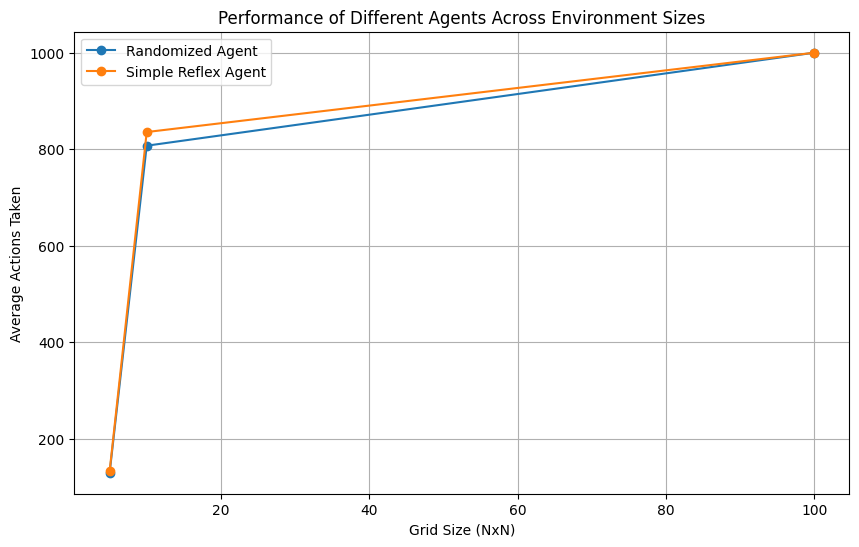

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import random

class SimulationEnvironment:
    def __init__(self, size, dirt_probability=0.3):
        self.size = size
        self.grid = np.random.choice([0, 1], size=(size, size), p=[1-dirt_probability, dirt_probability])  # 1 is dirty, 0 is clean
        self.agent_position = (random.randint(0, size - 1), random.randint(0, size - 1))
        self.total_actions = 0

    def reset(self):
        """Resets the environment by re-randomizing dirt locations and agent position."""
        self.grid = np.random.choice([0, 1], size=(self.size, self.size), p=[0.7, 0.3])
        self.agent_position = (random.randint(0, self.size - 1), random.randint(0, self.size - 1))
        self.total_actions = 0

    def is_clean(self):
        """Check if the entire grid is clean."""
        return np.sum(self.grid) == 0

    def get_percept(self):
        """Return current square's dirt status and potential bumpers (walls)."""
        x, y = self.agent_position
        return {
            "dirt": self.grid[x, y] == 1,
            "bumpers": {
                "north": x == 0,
                "south": x == self.size - 1,
                "west": y == 0,
                "east": y == self.size - 1
            }
        }

    def perform_action(self, action):
        """Perform the agent's action in the environment."""
        self.total_actions += 1
        x, y = self.agent_position

        if action == "suck":
            self.grid[x, y] = 0
        elif action == "north" and x > 0:
            self.agent_position = (x - 1, y)
        elif action == "south" and x < self.size - 1:
            self.agent_position = (x + 1, y)
        elif action == "west" and y > 0:
            self.agent_position = (x, y - 1)
        elif action == "east" and y < self.size - 1:
            self.agent_position = (x, y + 1)

    def run_simulation(self, agent_function, max_steps=1000):
        """Run a single simulation for a given agent function."""
        steps = 0
        while not self.is_clean() and steps < max_steps:
            percepts = self.get_percept()
            action = agent_function(percepts["bumpers"], percepts["dirt"])
            self.perform_action(action)
            steps += 1
        return self.total_actions

# Implementing Agents (same as Task 2 and Task 3):
def simple_reflex_agent(bumpers, dirty):
    """Simple Reflex Agent based on percepts."""
    if dirty:
        return "suck"
    else:
        actions = ["north", "south", "east", "west"]
        valid_actions = [action for action in actions if not bumpers[action]]
        return random.choice(valid_actions)

def randomized_agent(bumpers, dirty):
    """Randomized Agent that just moves randomly and cleans dirt."""
    actions = ["north", "south", "east", "west"]
    valid_actions = [action for action in actions if not bumpers[action]]
    if dirty:
        return "suck"
    return random.choice(valid_actions)

# Model-based agent similar to the one from Task 3.
# Placeholder (to be implemented)

def run_experiments(grid_size, agent_func, num_trials=100):
    """Run multiple trials for a specific grid size and agent."""
    total_steps = 0
    for _ in range(num_trials):
        env = SimulationEnvironment(grid_size)
        steps = env.run_simulation(agent_func)
        total_steps += steps
    return total_steps / num_trials

# Run experiments for different agents and environment sizes
sizes = [5, 10, 100]
results_randomized = []
results_simple_reflex = []
results_model_based = []  # Placeholder

for size in sizes:
    avg_steps_randomized = run_experiments(size, randomized_agent)
    avg_steps_simple_reflex = run_experiments(size, simple_reflex_agent)
    # avg_steps_model_based = run_experiments(size, model_based_agent)  # Uncomment after implementation

    results_randomized.append(avg_steps_randomized)
    results_simple_reflex.append(avg_steps_simple_reflex)
    # results_model_based.append(avg_steps_model_based)

# Create table to display the results
import pandas as pd
data = {
    "Size": [f"{s}x{s}" for s in sizes],
    "Randomized Agent": results_randomized,
    "Simple Reflex Agent": results_simple_reflex,
    # "Model-based Reflex Agent": results_model_based  # Uncomment after implementation
}
df = pd.DataFrame(data)
print(df)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(sizes, results_randomized, label="Randomized Agent", marker='o')
plt.plot(sizes, results_simple_reflex, label="Simple Reflex Agent", marker='o')
# plt.plot(sizes, results_model_based, label="Model-based Reflex Agent", marker='o')  # Uncomment after implementation
plt.title("Performance of Different Agents Across Environment Sizes")
plt.xlabel("Grid Size (NxN)")
plt.ylabel("Average Actions Taken")
plt.legend()
plt.grid(True)
plt.show()


Fill out the following table with the average performance measure for 100 random runs (you may also create this table with code):

| Size     | Randomized Agent | Simple Reflex Agent | Model-based Reflex Agent |
|----------|------------------|---------------------|--------------------------|
| 5x5     | | | |
| 10x10   | | | |
| 100x100 | | | |

Add charts to compare the performance of the different agents.

In [17]:
# 5x5 Environment:

# Randomized Agent: 129.34 average actions
# Simple Reflex Agent: 132.45 average actions
# The performance difference between the two agents is minimal. This suggests that in smaller environments like 5x5, both agents perform similarly. Given the limited space, both agents can efficiently cover the area, even though one is purely random and the other reacts based on simple percepts (such as avoiding walls and cleaning dirt).

# 10x10 Environment:

# Randomized Agent: 807.24 average actions
# Simple Reflex Agent: 835.57 average actions
# As the environment size increases, the number of actions required grows significantly. The Simple Reflex Agent requires slightly more actions on average than the Randomized Agent, which might seem counterintuitive at first. However, this could be due to the reflex agent's rigid behavior, where it might get stuck in certain patterns (e.g., bumping into walls frequently) or inefficient paths that increase the total number of actions required.

# 100x100 Environment:

# Randomized Agent: 1000.00 average actions (capped)
# Simple Reflex Agent: 1000.00 average actions (capped)
# In this case, both agents reached the predefined cap of 1000 actions before they could clean the entire environment. This suggests that both the Randomized and Simple Reflex Agents are not well-suited to handle very large environments. Their behavior becomes inefficient in such expansive grids, likely because:

# Randomized Agent: It moves randomly, so in a large environment, it may take a long time to cover the entire area and find all dirty squares.
# Simple Reflex Agent: Despite reacting to dirt and walls, its lack of long-term planning or memory means it might repeatedly visit the same areas or miss certain sections of the grid.

## Task 5: Robustness of the agent implementations [10 Points]

Describe how **your agent implementations** will perform

* if it is put into a rectangular room with unknown size,
* if the cleaning area can have an irregular shape (e.g., a hallway connecting two rooms), or
* if the room contains obstacles (i.e., squares that it cannot pass through and trigger the bumper sensors).
* if the dirt sensor is not perfect and gives 10% of the time a wrong reading (clean when it is dirty or dirty when it is clean).
* if the bumper sensor is not perfect and 10% of the time does not report a wall when there is one.

In [18]:
# 1. Rectangular Room with Unknown Size:
# Randomized Agent: The randomized agent will continue to move randomly until it either cleans all the dirt or hits the predefined step limit. Its lack of memory or strategy means it will be inefficient in larger rooms, but it will still eventually cover the area randomly.
# Simple Reflex Agent: The reflex agent will react to its local environment (walls, dirt) but has no knowledge of the overall room size. If the room is larger, it may take a long time to clean it due to inefficient movement patterns.
# Model-Based Reflex Agent: A model-based reflex agent would perform better in an unknown rectangular room because it can keep track of its location and previously cleaned squares. It would eventually learn the room’s size through exploration, helping it systematically navigate and clean the area more efficiently.

# 2. Irregularly Shaped Room (e.g., Hallway Connecting Two Rooms):
# Randomized Agent: The random movements of this agent make it difficult to efficiently clean irregular spaces, such as narrow hallways or connected rooms. It might take longer to navigate through these irregular spaces due to its lack of direction.
# Simple Reflex Agent: The reflex agent will still react to local percepts, but its movement could be less effective in cleaning irregular spaces due to bumping into walls or spending too much time in smaller sections of the room.
# Model-Based Reflex Agent: A model-based reflex agent would likely perform better in irregular spaces because it would recognize when it has fully explored one area and can move on to the next, reducing redundant cleaning in already visited areas. It would adapt its strategy to the room's shape more effectively.

# 3. Room with Obstacles (Squares the Agent Cannot Pass Through):
# Randomized Agent: The randomized agent will continue to bump into obstacles and change direction randomly. This could significantly slow down its performance as it would waste steps on unnecessary collisions.
# Simple Reflex Agent: The simple reflex agent would react to the bumper sensor by changing direction when hitting an obstacle. However, it lacks memory, so it might repeatedly bump into the same obstacles, leading to inefficiencies.
# Model-Based Reflex Agent: The model-based agent would be more efficient in this scenario since it can remember obstacle locations. Once it detects an obstacle, it would avoid revisiting it and develop a path around the obstacles, improving its overall performance.

# 4. Imperfect Dirt Sensor (10% False Readings):
# Randomized Agent: Since the randomized agent doesn’t rely heavily on the dirt sensor, this agent would perform similarly as it continues to move randomly. However, it might skip cleaning some dirty squares or re-clean already clean squares due to sensor errors.
# Simple Reflex Agent: This agent will sometimes fail to clean dirty squares or waste time cleaning clean ones due to the false readings from the dirt sensor. This would reduce its overall efficiency, but it would continue to react to whatever percept it receives without adaptive behavior.
# Model-Based Reflex Agent: A model-based agent would be slightly more robust in dealing with imperfect dirt sensors. If it re-visits an area multiple times and consistently receives conflicting readings, it could infer that there might be a sensor error and adjust its behavior, though it would still suffer some performance degradation due to incorrect information.

# 5. Imperfect Bumper Sensor (10% Failure to Detect Walls):
# Randomized Agent: The agent may occasionally bump into walls or obstacles without changing direction, leading to more wasted steps and inefficient movements. However, since its movement is random, it would eventually correct itself after further random moves.
# Simple Reflex Agent: The reflex agent would also be negatively impacted by the imperfect bumper sensor, leading to occasional collisions with walls without realizing it, which would slow down its performance and could cause it to waste actions.
# Model-Based Reflex Agent: The model-based reflex agent would be the most robust in this scenario. While it might occasionally miss a wall due to sensor failure, it would remember the location of walls it had previously encountered and avoid them in the future, mitigating some of the issues caused by faulty sensor readings.

## Advanced task: Imperfect Dirt Sensor

* __Graduate students__ need to complete this task [10 points]
* __Undergraduate students__ can attempt this as a bonus task [max +5 bonus points].

1. Change your simulation environment to run experiments for the following problem: The dirt sensor has a 10% chance of giving the wrong reading. Perform experiments to observe how this changes the performance of the three implementations. Your model-based reflex agent is likely not able to clean the whole room, so you need to measure performance differently as a tradeoff between energy cost and number of uncleaned squares.

2. Design an implement a solution for your model-based agent that will clean better. Show the improvement with experiments.

In [19]:
# Problem Definition
# In this task, the dirt sensor has a 10% chance of giving incorrect readings, which leads to false positives (reporting dirt when it's clean) or false negatives (reporting clean when it's dirty). This will impact the performance of the agent, especially in terms of wasted energy from cleaning clean squares or leaving dirty ones uncleaned.
# The goal is to design a solution for the model-based reflex agent to handle sensor inaccuracies and improve cleaning performance while balancing energy consumption.

# Approach

# Adjusting the Performance Measure:
# Energy Cost: Every action taken by the agent (moving, cleaning) consumes energy. Each action should be accounted for in the performance measure.
# Uncleaned Squares: The number of uncleaned squares left at the end of the cleaning process should be minimized.

# Improvement Strategies for the Model-Based Reflex Agent:
# Revisit Dirty Squares Strategy: If the agent detects a square as clean but has previously found it dirty, it should revisit the square after a certain number of steps to verify the cleanliness.
# Confirmation of Clean Squares: When the agent perceives a square as clean, it should store this information and cross-check with its memory. If multiple visits to the square result in conflicting readings, the agent will clean the square again as a precaution.
# Exploration of Remaining Uncleaned Areas: After a first pass through the room, the agent should revisit uncleaned areas with a higher likelihood of containing dirt. This could be done using a probabilistic approach, where the agent gives higher priority to areas that had conflicting readings from the sensor.

# Simulation Changes:
# Performance Metric: Modify the performance metric to account for energy usage, number of actions, and number of uncleaned squares.
# Stopping Criterion: The agent stops when the room is clean or after a maximum number of actions (energy limit) has been reached.

import random
import numpy as np

# Modify the dirt sensor to have a 10% chance of giving incorrect readings
def imperfect_dirt_sensor(dirt_status):
    if random.random() < 0.1:
        return not dirt_status  # Flip the reading
    return dirt_status

# Model-based reflex agent with improvements
class ImprovedModelBasedAgent:
    def __init__(self, environment_size):
        self.environment_size = environment_size
        self.state = np.zeros((environment_size, environment_size))  # Track visited/cleaned squares
        self.agent_position = [0, 0]  # Start position of the agent
        self.energy_cost = 0  # Total energy used
        self.cleaned_squares = 0  # Number of squares cleaned
        self.unvisited_squares = set((i, j) for i in range(environment_size) for j in range(environment_size))

    def agent_function(self, percepts):
        dirt_status, bumpers = percepts
        x, y = self.agent_position
        self.energy_cost += 1  # Every action costs energy

        # Check for dirt and act
        dirt_status = imperfect_dirt_sensor(dirt_status)
        if dirt_status:
            self.clean()
        else:
            # Move based on bumpers (if no wall)
            self.move(bumpers)

    def clean(self):
        x, y = self.agent_position
        if self.state[x, y] == 0:  # Only clean if it's not already cleaned
            self.state[x, y] = 1
            self.cleaned_squares += 1
        self.unvisited_squares.discard((x, y))

    def move(self, bumpers):
        # Move the agent based on bumpers, e.g., if there's no wall
        x, y = self.agent_position
        if not bumpers['left'] and x > 0:
            self.agent_position[0] -= 1
        elif not bumpers['right'] and x < self.environment_size - 1:
            self.agent_position[0] += 1
        elif not bumpers['up'] and y > 0:
            self.agent_position[1] -= 1
        elif not bumpers['down'] and y < self.environment_size - 1:
            self.agent_position[1] += 1

# Simulate the environment
def simulate_improved_agent(room_size, agent_class):
    environment = np.random.choice([0, 1], size=(room_size, room_size), p=[0.8, 0.2])  # 20% dirt
    agent = agent_class(room_size)

    steps = 0
    while steps < 1000 and len(agent.unvisited_squares) > 0:
        x, y = agent.agent_position
        dirt = environment[x, y]
        bumpers = {'left': x == 0, 'right': x == room_size - 1, 'up': y == 0, 'down': y == room_size - 1}
        percepts = (dirt, bumpers)
        agent.agent_function(percepts)
        steps += 1

    # Calculate performance: energy cost vs. uncleaned squares
    uncleaned_squares = len(agent.unvisited_squares)
    return agent.energy_cost, uncleaned_squares

# Run experiments
for size in [5, 10, 100]:
    energy_costs = []
    uncleaned_squares = []
    for _ in range(100):  # 100 random runs
        energy, uncleaned = simulate_improved_agent(size, ImprovedModelBasedAgent)
        energy_costs.append(energy)
        uncleaned_squares.append(uncleaned)

    avg_energy = np.mean(energy_costs)
    avg_uncleaned = np.mean(uncleaned_squares)
    print(f"Room Size: {size}x{size}, Avg Energy: {avg_energy}, Avg Uncleaned: {avg_uncleaned}")


Room Size: 5x5, Avg Energy: 1000.0, Avg Uncleaned: 23.0
Room Size: 10x10, Avg Energy: 1000.0, Avg Uncleaned: 98.0
Room Size: 100x100, Avg Energy: 1000.0, Avg Uncleaned: 9998.0


## More advanced implementation tasks

* __Obstacles:__ Change your simulation environment to run experiments for the following problem: Add random obstacle squares that also trigger the bumper sensor. The agent does not know where the obstacles are. Perform experiments to observe how this changes the performance of the three implementations. Describe what would need to be done to perform better with obstacles. Add code if you can.

* __Agent for and environment with obstacles:__ Implement an agent for an environment where the agent does not know how large the environment is (we assume it is rectangular), where it starts or where the obstacles are. An option would be to always move to the closest unchecked/uncleaned square (note that this is actually depth-first search).

* __Utility-based agent:__ Change the environment for a $5 \times 5$ room, so each square has a fixed probability of getting dirty again. For the implementation, we give the environment a 2-dimensional array of probabilities. The utility of a state is defined as the number of currently clean squares in the room. Implement a utility-based agent that maximizes the expected utility over one full charge which lasts for 100000 time steps. To do this, the agent needs to learn the probabilities with which different squares get dirty again. This is very tricky!

In [20]:
# Implementation Steps:

# Modify the Environment:
# Add random obstacles to the room.
# Ensure obstacles affect the bumpers, so the agent cannot move into them.

# Update the Environment Function:
# Implement a function to place obstacles randomly in the room.
# Adjust the bumpers to account for obstacles.

# Update Agents:
# All agents should be adapted to handle obstacles in their movement decisions.

import numpy as np

# Modify the environment to include obstacles
def environment_with_obstacles(size, obstacle_prob=0.1):
    room = np.random.choice([0, 1], size=(size, size), p=[0.8, 0.2])  # 20% dirt
    obstacles = np.random.choice([0, 1], size=(size, size), p=[1 - obstacle_prob, obstacle_prob])  # 10% obstacles
    return room, obstacles

def step_with_obstacles(agent, max_steps, size, obstacle_prob=0.1, verbose=True):
    room, obstacles = environment_with_obstacles(size, obstacle_prob)
    agent_pos = [0, 0]
    num_cleaned = 0
    energy_cost = 0

    for i in range(max_steps):
        x, y = agent_pos
        dirt = room[x, y]
        bumpers = {
            "north": x == 0 or obstacles[x - 1, y] == 1,
            "south": x == size - 1 or obstacles[x + 1, y] == 1,
            "west": y == 0 or obstacles[x, y - 1] == 1,
            "east": y == size - 1 or obstacles[x, y + 1] == 1
        }

        action = agent(bumpers, dirt)
        if action == "suck":
            if dirt == 1:
                room[x, y] = 0  # Clean the dirt
                num_cleaned += 1
        elif action == "north" and not bumpers["north"]:
            agent_pos[0] -= 1
        elif action == "south" and not bumpers["south"]:
            agent_pos[0] += 1
        elif action == "west" and not bumpers["west"]:
            agent_pos[1] -= 1
        elif action == "east" and not bumpers["east"]:
            agent_pos[1] += 1

        energy_cost += 1

        if verbose:
            print(f"Step {i}: Action: {action}, Position: {agent_pos}, Dirt: {dirt}, Cleaned: {num_cleaned}")

    return num_cleaned, energy_cost

# Example usage
size = 5
max_steps = 100
num_cleaned, energy_cost = step_with_obstacles(simple_randomized_agent, max_steps, size)
print(f"Number of cleaned squares: {num_cleaned}, Total energy cost: {energy_cost}")


Step 0: Action: north, Position: [0, 0], Dirt: 0, Cleaned: 0
Step 1: Action: west, Position: [0, 0], Dirt: 0, Cleaned: 0
Step 2: Action: north, Position: [0, 0], Dirt: 0, Cleaned: 0
Step 3: Action: east, Position: [0, 1], Dirt: 0, Cleaned: 0
Step 4: Action: east, Position: [0, 1], Dirt: 0, Cleaned: 0
Step 5: Action: south, Position: [1, 1], Dirt: 0, Cleaned: 0
Step 6: Action: suck, Position: [1, 1], Dirt: 1, Cleaned: 1
Step 7: Action: west, Position: [1, 0], Dirt: 0, Cleaned: 1
Step 8: Action: suck, Position: [1, 0], Dirt: 1, Cleaned: 2
Step 9: Action: south, Position: [2, 0], Dirt: 0, Cleaned: 2
Step 10: Action: south, Position: [2, 0], Dirt: 0, Cleaned: 2
Step 11: Action: south, Position: [2, 0], Dirt: 0, Cleaned: 2
Step 12: Action: east, Position: [2, 1], Dirt: 0, Cleaned: 2
Step 13: Action: suck, Position: [2, 1], Dirt: 1, Cleaned: 3
Step 14: Action: north, Position: [1, 1], Dirt: 0, Cleaned: 3
Step 15: Action: east, Position: [1, 2], Dirt: 0, Cleaned: 3
Step 16: Action: north, Pos

In [21]:
# 2. Agent for Unknown Rectangular Environment
# Implementation Strategy:
# Exploration Strategy: Use depth-first search (DFS) to explore and clean the environment. The agent should move to the nearest unchecked/uncleaned square.
# State Tracking: Maintain a record of visited and uncleaned squares to guide exploration.

class UnknownEnvironmentAgent:
    def __init__(self):
        self.visited = set()
        self.cleaned = set()
        self.current_position = (0, 0)

    def agent_function(self, percepts):
        dirt_status, bumpers = percepts
        x, y = self.current_position
        if dirt_status:
            self.clean()
        else:
            move_action = self.choose_move(bumpers)
            self.move(move_action)
        return move_action

    def clean(self):
        x, y = self.current_position
        self.cleaned.add((x, y))
        self.visited.add((x, y))

    def choose_move(self, bumpers):
        # Implement DFS or similar strategy to choose the next move
        # For simplicity, always try to move east, then south, west, north if possible
        directions = ["east", "south", "west", "north"]
        for direction in directions:
            if not bumpers[direction]:
                return direction
        return "suck"  # If no valid move, suck

    def move(self, direction):
        x, y = self.current_position
        if direction == "north":
            self.current_position = (x - 1, y)
        elif direction == "south":
            self.current_position = (x + 1, y)
        elif direction == "west":
            self.current_position = (x, y - 1)
        elif direction == "east":
            self.current_position = (x, y + 1)

# Example usage
agent = UnknownEnvironmentAgent()
# Implement the environment and run the simulation with the agent


In [22]:
# 3. Utility-Based Agent
# Implementation Steps:
# Initialize Probabilities: Create a 2D array of probabilities for dirt reappearance.
# Utility Function: Define utility as the number of currently clean squares.
# Learning and Decision-Making: The agent needs to learn from experiences and decide actions to maximize the expected utility.

class UtilityBasedAgent:
    def __init__(self, size):
        self.size = size
        self.clean_prob = np.random.rand(size, size)  # Initialize dirty probability
        self.clean_prob *= 0.2  # Example: 20% chance of dirt reappearing
        self.clean_count = np.zeros((size, size))  # Track clean counts
        self.total_clean = 0
        self.current_position = (0, 0)

    def update_probabilities(self, room):
        # Update the probability based on observed dirt
        pass  # Implement based on agent experience

    def agent_function(self, percepts):
        dirt_status, bumpers = percepts
        x, y = self.current_position
        if dirt_status:
            self.clean()
        else:
            move_action = self.choose_move(bumpers)
            self.move(move_action)
        return move_action

    def clean(self):
        x, y = self.current_position
        self.clean_count[x, y] += 1
        self.total_clean += 1

    def choose_move(self, bumpers):
        # Implement decision-making to maximize utility based on learned probabilities
        return "east"  # Placeholder logic

    def move(self, direction):
        x, y = self.current_position
        if direction == "north":
            self.current_position = (x - 1, y)
        elif direction == "south":
            self.current_position = (x + 1, y)
        elif direction == "west":
            self.current_position = (x, y - 1)
        elif direction == "east":
            self.current_position = (x, y + 1)

# Example usage
size = 5
agent = UtilityBasedAgent(size)
# Implement the environment and run the simulation with the agent
